# Prostate cancer prediction 

#### Data

We consider a medical study conducted on 97 men with prostate cancer.
The focus is on the relationship between the prostate specific antigen (psa), which is elevated in men with prostate cancer, and others clinical measures. 
The others clinical measures are the predictors variables, gathered in a medical examination, and the amount of expression of the antigen associated with the cancer detection is the response variable (lpsa).

Thus the data frame is made of 97 observations on 9 variables:
* lcavol: log cancer volume
* lweight: log prostate weight
* age: patient age in years
* lbph: log amount of benign prostatic hyperplasia
* svi: seminal vesicle invasion
* lcp: log of capsular penetration
* gleason: Gleason score
* pgg45: percent of Gleason score 4 or 5
* lpsa: log prostate specific antigen

The goal is to find models predicting the response lpsa.

#### Models

The data are represented by $n$ points in $p$ dimensions, thus the predictor variable is written $X\in\mathbb{R}^{n\times p}$ and the response variable is $y\in\mathbb{R}^n$.

In this work, we're insterested in the relationship between the predictor $X$ and the response $y$.
To determine this relationship, we adopt regression models.
The standard baseline is achieved with linear regression and we compare results for regularized regressions: **Ridge regression**, **Lasso** and **Elastic Net**.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge 

## Data exploration

In [2]:
lpsa_data = pd.read_csv('prostate_dataset.txt', delimiter='\t')
lpsa_data.head()

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


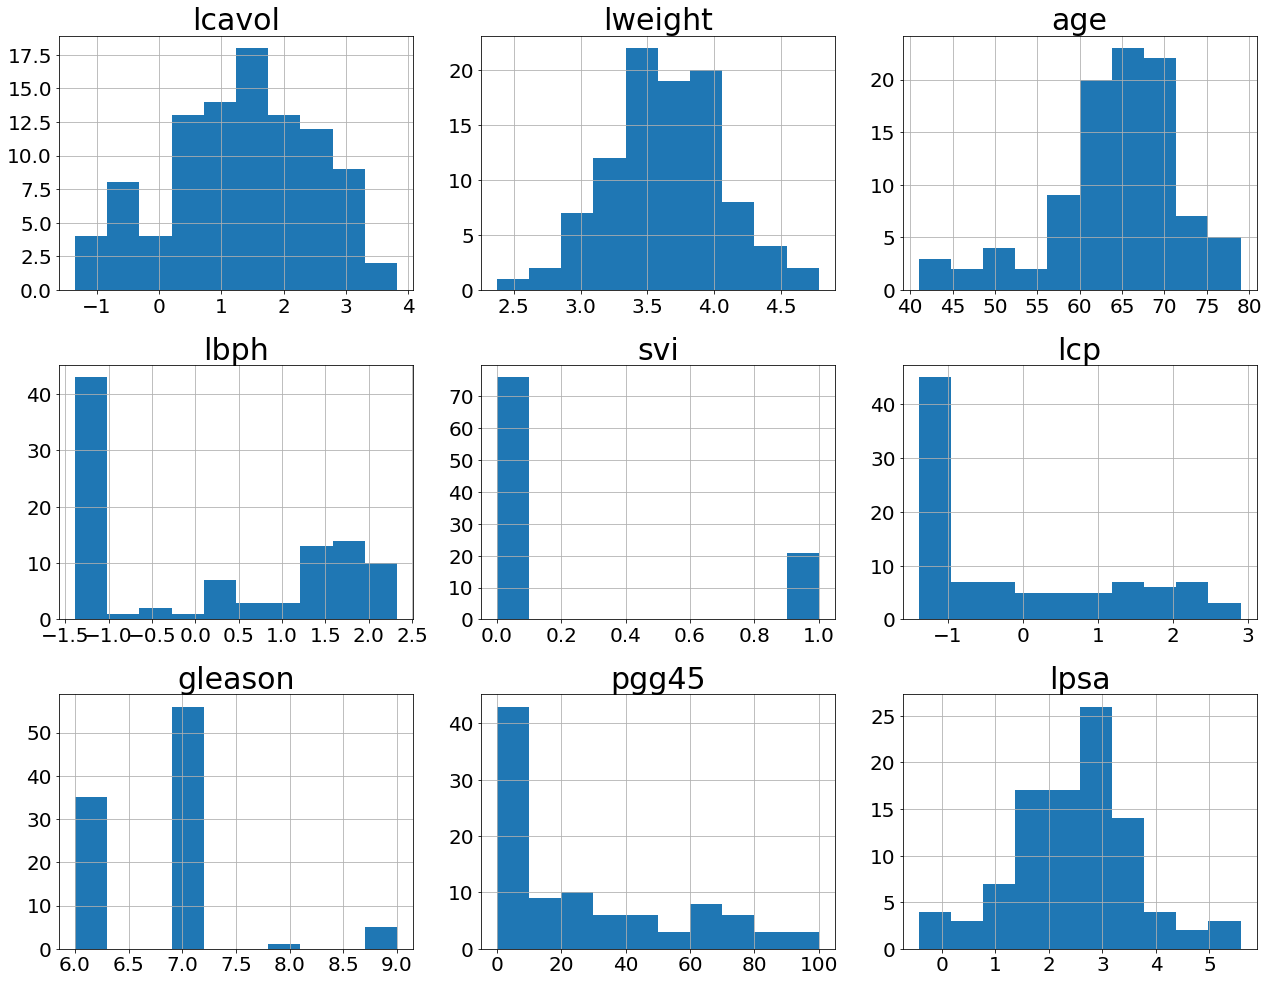

In [3]:
# Data distribution
def data_distribution(data):
    nb_sample, nb_var = data.shape
    labels = list(data)
    plt.figure(figsize = (18,14))
    for i in range(nb_var):
        ax = plt.subplot(3,3, i + 1)     
        data_col = data.iloc[:, i]
        data_col.hist()
        plt.title(f'{labels[i]}')
        ax.title.set_fontsize(30)
        for item in ([ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)
    plt.tight_layout(pad=2,w_pad=2,h_pad=2)
    plt.show()
data_distribution(lpsa_data.iloc[:,1:])

* lspa is almost normally distributed.
* the presence of svi is binary
* lcp: due to not proper measurements, for small values of capsular penetration, it has been arbitrarily set to 0.25.
* gleason and pgg45 don't seem to be correlated...

Let see the correlation between variables.

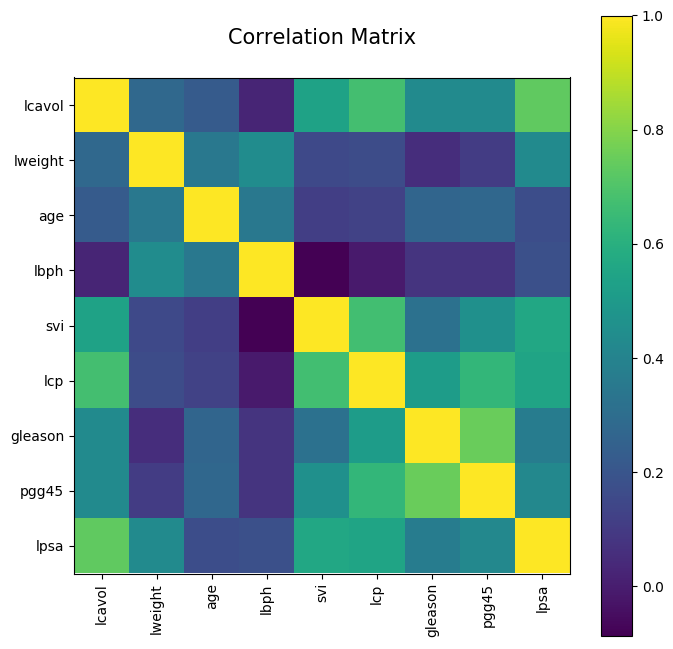

In [4]:
# Correlation matrix
def correlation_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(8,8), dpi=100)
    corr_mat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corr_mat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()
correlation_matrix(lpsa_data.iloc[:,1:])

* The more correlated variable with the response lpsa is lcavol.
  Thus in a data analysis, the lcavol variable must be included as a predictor.

* The correlation matrix shows that gleason and pgg45 are actually correlated. 
  Indeed, the variable pgg45 measures the percentage of 4 or 5 Gleason scores that were recorded before the final current Gleason score.

Let plot the relationship between the response lpsa and the lcavol feature.

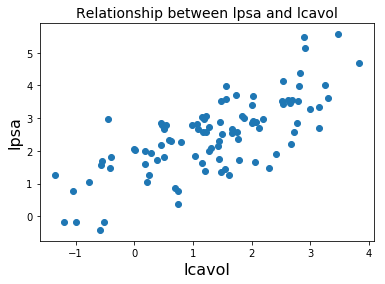

In [5]:
plt.scatter(lpsa_data['lcavol'], lpsa_data['lpsa'])
plt.xlabel('lcavol', fontsize=16)
plt.ylabel('lpsa', fontsize=16)
plt.title("Relationship between lpsa and lcavol", fontsize=14)
plt.show()

There is a pretty clear linear relationship with positive correlation, as seen on the correlation matrix.

### Data train/test splitting

In [6]:
# train : the first columns 
# test : the last columns 
n_split = 60
X_train = lpsa_data.iloc[:n_split,1:-2]
X_test = lpsa_data.iloc[n_split:,1:-2]
y_train = lpsa_data.iloc[:n_split,-1] # lpsa column
y_test = lpsa_data.iloc[n_split:,-1]  # lpsa column

# Learning models


# 1) Linear regression baseline

The linear regression attemps to model the relationship between the predictors variables $X$ and the response variable $y$.
It consists in finding a linear function $f:\mathbb{R}^p \to \mathbb{R}$ which predicts the response $y_i$ from the predictors $X_{i1},...,X_{ip}$ given $n$ observations for $i=1,...,n$.
Formally, the linear regression approximates $y_i$ by $\beta_0+\beta_1 X_{i1}+...+\beta_p X_{ip}+\epsilon_i$ for $i=1,...,n$ where $\epsilon_i$ is a residual term corresponding to the error model.
The regression coefficients $\beta_0,...,\beta_p$, or the weights, are the parameters to be estimated.

The coefficients $\beta_0,...,\beta_p$ are determinated by the least squares method that minimizes the sum of squared residuals, and the formulation of the problem leads to solve a normal equation.

In Python, the linear regression is implemented as  [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) in the linear_model module of scikit-learn.

In [7]:
# Linear regression model
lr = linear_model.LinearRegression()
# learn the model on the train set
lr.fit(X_train,y_train)
# baseline error
y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_pred, y_test)
baseline_error = baseline_error / np.linalg.norm(y_test)
print("Linear regression error: %0.4f" % baseline_error)

Linear regression error: 0.1296


# 2) Regularization

In order to avoid over-learning, the regularization method allows to control the model complexity.
The model minimizes the error (from the least squares of the linear regression) plus a regularization term $\lambda Reg(\beta)$ measuring the complexity, where $Reg(\beta)$ is a penalty term and $\lambda$ is an hyper-parameter.
The hyper-parameter controls the relative influence of the error term and the amount of regularization.
The optimal value of $\lambda$ can be found by cross validation (see repository [cross-validation](https://github.com/christelle-git/cross-validation/)). 

## 2.1) Ridge regression 

In the Ridge regression, the regularization term is $Reg(\beta) = ||\beta||_2^2$.
The Ridge regression allows to reduce the magnitude of the weights $\beta_i$ of the linear regression, and thus avoid over-learning.
The Ridge regression has a grouped selection effect: the correlated variables have the same weights.

In [8]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) # alpha <=> lambda hyper-parameter

coef_ridge = []
err_ridge = []
baseline = []
for a in alphas:
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    coef_ridge.append(ridge.coef_)
    y_pred = ridge.predict(X_test)
    ridge_error = metrics.mean_squared_error(y_pred, y_test)
    ridge_error = ridge_error / np.linalg.norm(y_test)
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

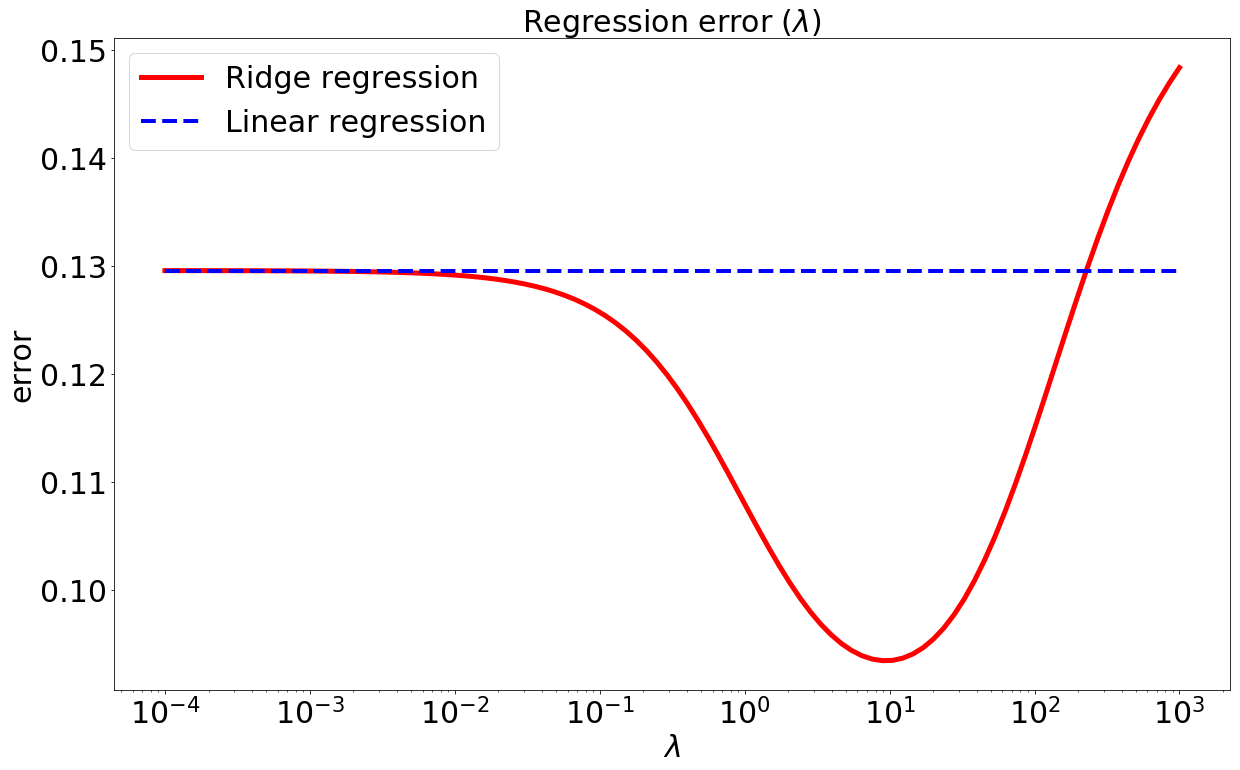

In [9]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

* The optimal value of the regularization coefficient $\lambda$ is around 10.
* For $\lambda \to 0$ the regularization terms vanishes leading to the same result as linear regression.
* For $\lambda \to \infty$ the regularization term magnitude dominates.

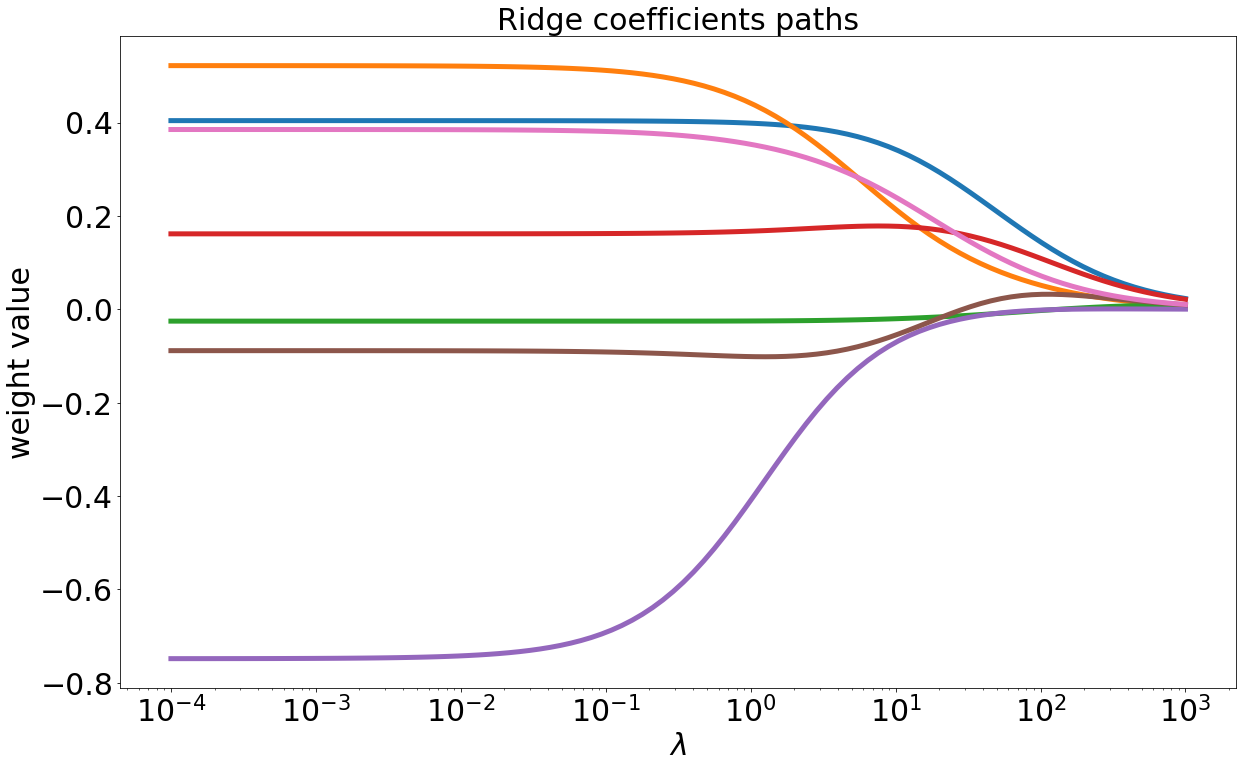

In [10]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_ridge, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.show()

* The ridge regression restricts somes variables by reducing their weights magnitude.
* The correlated variables have the same weight.

## 2.2) Least Absolute Shrinkage and Selection Operator

The following method goes further by selecting somes variables to be removed from the Ridge regression, thus reducing the dimension.
The method is called Least Absolute Shrinkage and Selection Operator (Lasso) and the resulting simplified model is a **sparse model** or parsimonious model.
In the Lasso, the regularization term is defined by $Reg(\beta) = ||\beta||_1$.

The Lasso performs a model's feature selection: for correlated variables, it retains only one variable and sets other correlated variables to zero.
The counterpart is that it obviously induces a loss of information resulting in lower accuracy.

In [11]:
lasso = linear_model.Lasso(fit_intercept=False)

coef_lasso = []
err_lasso = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = metrics.mean_squared_error(y_pred, y_test)
    lasso_error = lasso_error / np.linalg.norm(y_test)
    err_lasso.append(lasso_error)

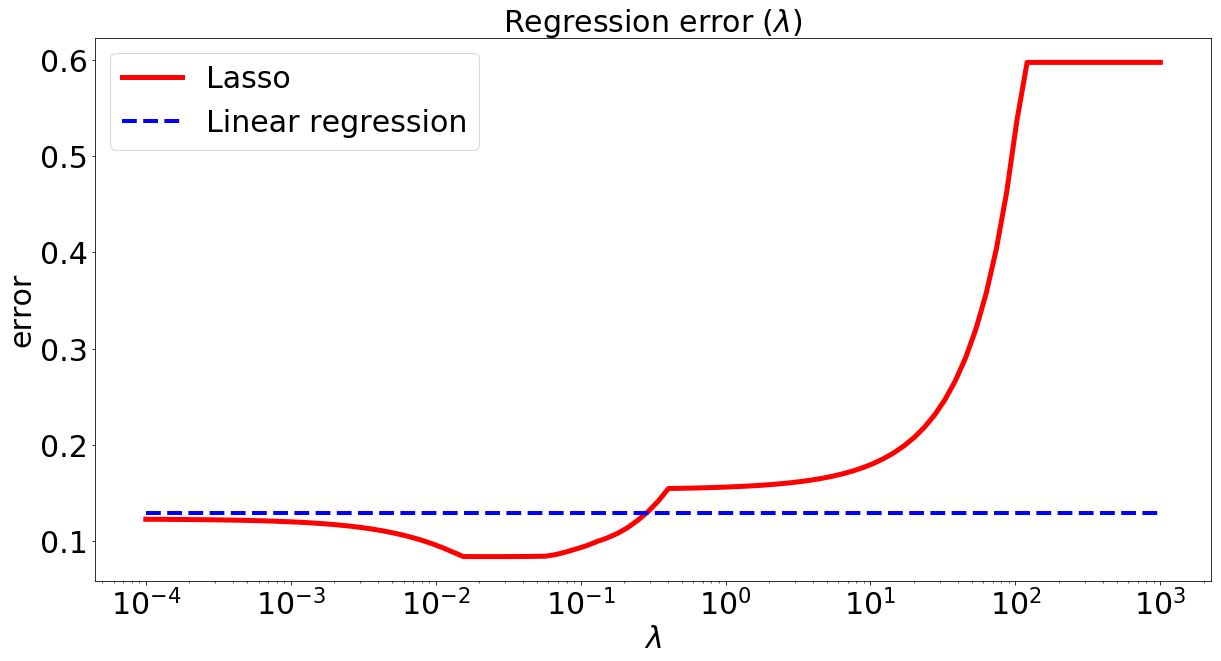

In [12]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

* The optimal value of the regularization coefficient $\lambda$ is between $10^{-2}$ and $10^{-1}$.
* For $\lambda \to 0$ the regularization terms vanishes so the Lasso regression tends to the linear regression.
* For $\lambda \to \infty$ the regularization term magnitude dominates the error.

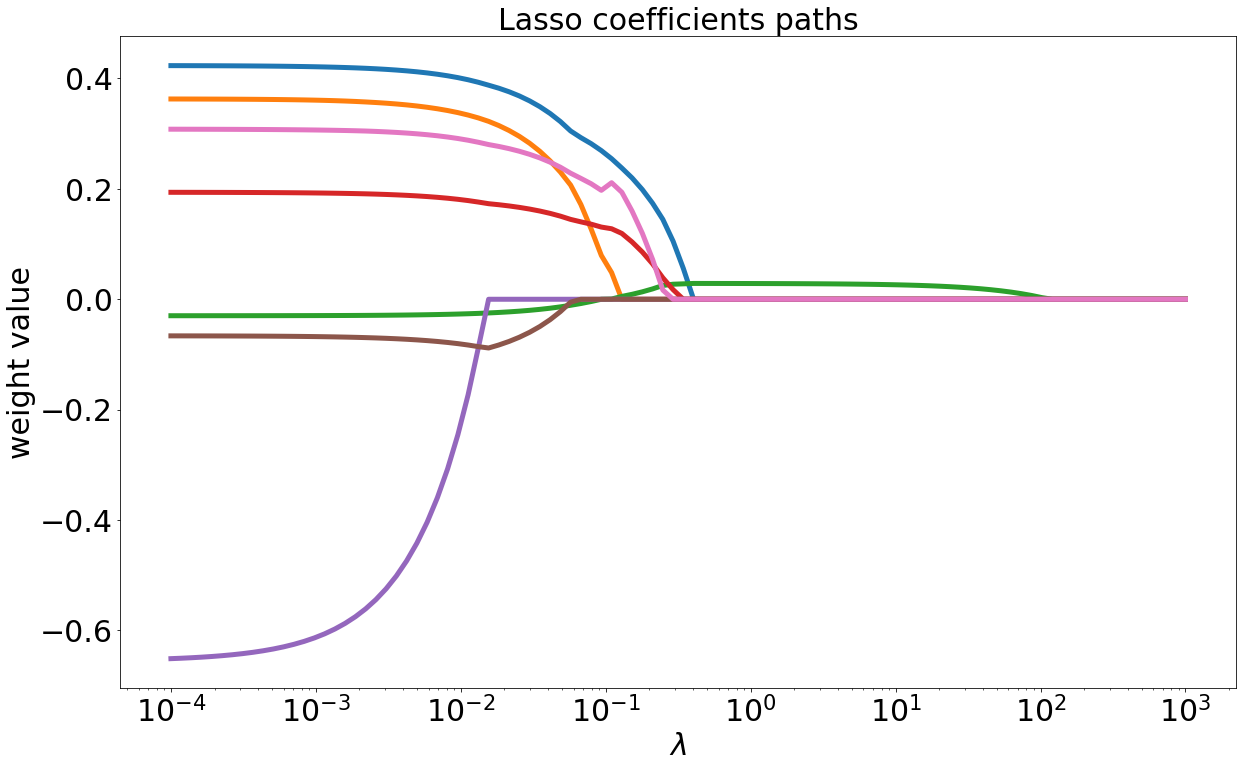

In [13]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.show()

* The Lasso removes somes variables by putting their weight to zero.<br>
  This is the case if two variables are correlated.
* As $\lambda \to \infty$ weights vanish so the model becomes very **sparse**.

## 2.3) Elastic net

The Elastic Net method is a hybrid of the Ridge regression and the Lasso, thus overcomes the issue of losing information.
The regularization term combines both the $L_1$ and the $L_2$ regularizations.
More precisely, the regularisation term is set to $Reg(\beta) = \lambda((1-\alpha)||\beta||_1+\alpha||\beta||_2^2)$ where $\alpha$ is an additional parameter to fit.

The Elastic net has a selecting effect on variables as Lasso but keep correlated variables as Ridge regression.
Thus the Elastic net model is less sparse than the Lasso, keeping more information. 
However the model is more demanding in computational resources.

In what follows we present results for $\alpha=0.5$.

In [14]:
coef_eln = []
err_eln = []
baseline = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=0.5)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = metrics.mean_squared_error(y_pred, y_test)
    elasticnet_error = elasticnet_error / np.linalg.norm(y_test)
    err_eln.append(elasticnet_error)
    baseline.append(baseline_error)

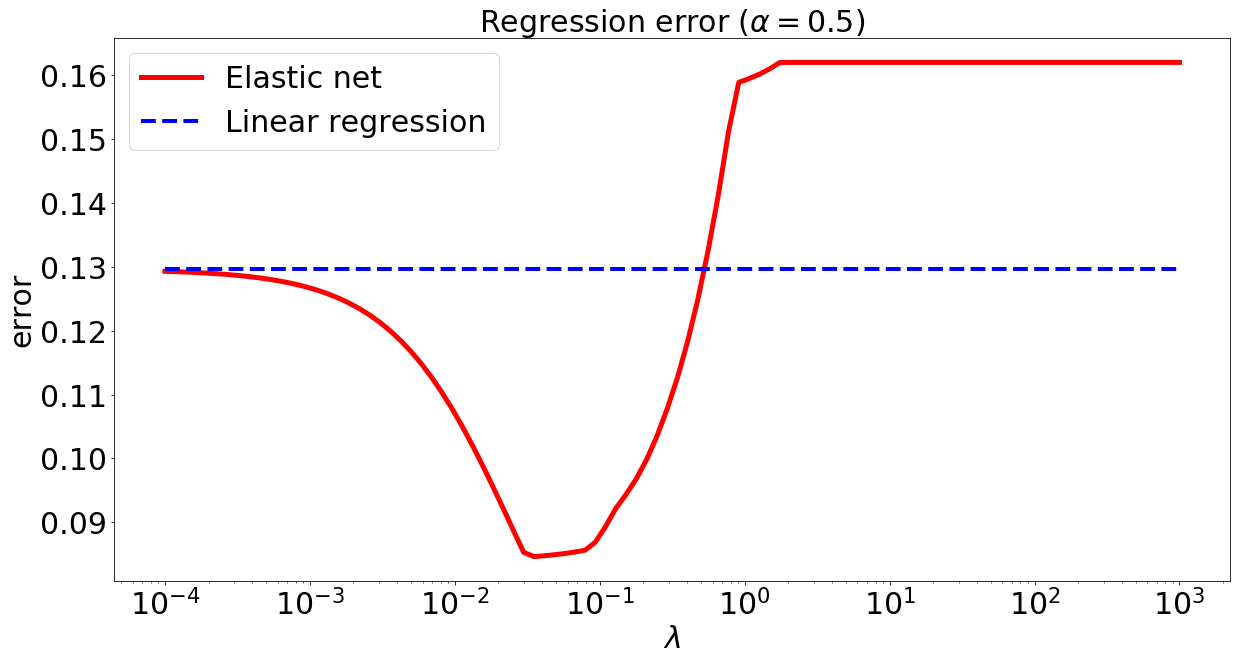

In [15]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\alpha=0.5$)', fontsize=30)
plt.show()

* The optimal value of the regularization coefficient $\lambda$ is between $10^{-2}$ and $10^{-1}$.
* For $\lambda \to 0$ the regularization terms vanishes leading to the same result as linear regression.
* For $\lambda \to \infty$ the regularization term magnitude dominates the error which is smaller than with the Lasso.

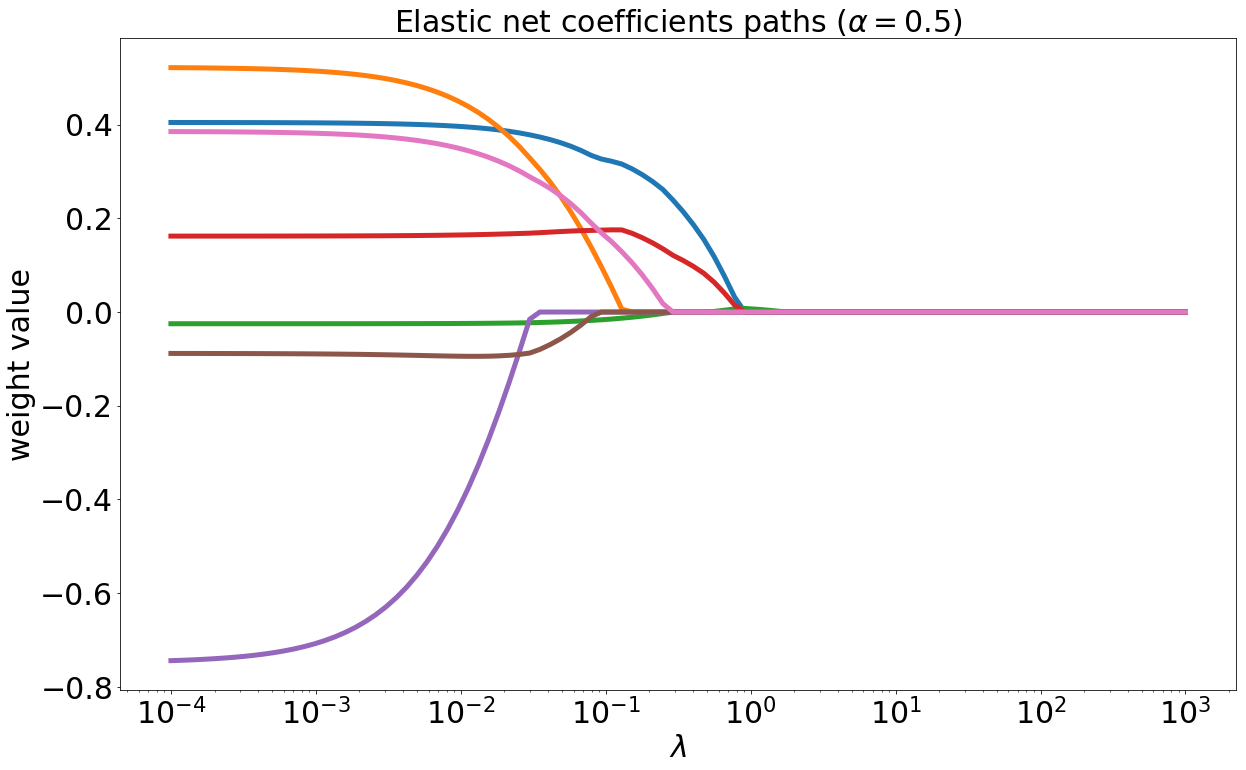

In [16]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($\alpha=0.5$)', fontsize=30)
plt.show()

* As expected the Elastic net keeps more variables than the Lasso.
* Better performance can be obtained by varying the hyper-parameter $\alpha$ value.


<br>

# Model selection 

In [17]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

Linear regression error:   0.1296
Minimun ridge error:       0.0934
Minimum lasso error:       0.0839
Minimum elastic net error: 0.0846


* The Lasso performs better than others methods (Elastic net: $\alpha=0.5$). 
* The Lasso is more parsimonious but there is likely to be a loss of accuracy.
* The Elastic net performs better than the Ridge regression (with $\alpha=0.5$).
* The Elastic net can be tuned to outperform Lasso but it is more demanding in computational resources.

**=> The Elastic net is a good trade-off for accuracy and computational cost balance between the Ridge regression and the Lasso**.


In order to optimize the model by fitting the optimal parameters, a cross validation can be performed.
The functions sklearn.linear_model.RidgeCV, sklearn.linear_model.LassoCV and sklearn.linear_model.ElasticNetCV in Python perform an automatic tunning of hyperparameters for the Rigde regression, the Lasso and the Elastic Net respectively.